In [1]:
#!/usr/local/lib/anaconda3/bin/python
# -*- coding: utf-8 -*-
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import random
import pandas as pd
import csv
from scipy import optimize

2.0 1.15


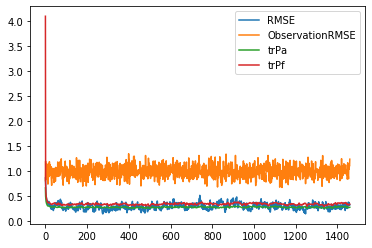

0.3078180874780319


In [28]:
# ETKF



def L96(Xa,F):

    F_ = (np.roll(Xa, -1,axis=0) - np.roll(Xa, 2,axis=0)) * np.roll(Xa, 1,axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb
def Forecast(Xa,m,b,L):
    h = 0.05 
    F = 8.0
    
    
    Xf = np.empty((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    #dX = [Xf[:,k]-Xf_ for k in range(m)]
    dXf = Xf - Xf_.reshape(-1,1)
    #dXf = np.array(dX).reshape(m,N).T
    dXf = dXf*b
    #print(dXf)
    Pf = dXf @ dXf.T/(m-1)
    Pf = Pf*L
    
    return Xf,Pf,dXf,Xf_

def Analysis(Xf,Pf,dXf,Xf_,y,m,a,mask,L):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,mask,axis=0) #観測欠損 #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    dY = H @ dXf
    #カルマンゲインの導出
    A = H @ Pf @ H.T + R
    A_inv = np.linalg.inv(A)
    K = Pf @ H.T @ A_inv
    #K = K*L
    
    Xa_ = Xf_ + K @ (y - H @ Xf_)
    E = np.eye(m)
    TT = E - dY.T @ np.linalg.inv(dY @ dY.T+(m-1)*R) @ dY
    #print(TT)
    
    la,v = np.linalg.eigh(TT)
    #print(v)
    D = np.diag(np.sqrt(la))
    #print(D)
    U = np.array(v).reshape(m,m)
    
    T = U @ D
    #print(T @ T.T)
    dXa = dXf @ T
    Xa = np.zeros((N,m))
    Xa = dXa + Xa_.reshape(-1,1)
    
    Pa = dXa @ dXa.T/(m-1)
    
    return Xa,Pa,Xa_


t = 1460
N = 40
m = 20
h = 0.05 
F = 8.0
#初期値
Xa = np.empty((N,m))
Xc = np.random.rand(N,m)
for j in range(500):
    Xb = Rungekutta4(Xc,h,F)
    Xc = Xb
Xa = Xb
#plt.plot(Xa[:,9])
#plt.plot(Xa[:,8])
#plt.show()

dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
RMSE = []
TrPa = []
TrPf = []
A = []
B = []
for i in range(1):
    a = 0
    sigma = 2.0 # localization parameter
    for j in range(1):
        b = 1.15 # inflation parameter
        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        for k in range(t):
            
            """
            l = np.arange(N).tolist()
            loc = random.sample(l,a)
            loc.sort()
            for i in range(a):
                df = dataset.drop(str(loc[i]),axis=1)
                dataset = df
            y = dataset.values 
            y = y.reshape(1460,N-a)
            """
            
            mask = np.random.choice(40,a,replace=False)
            y_ =np.delete(Y[k],mask)
            D=np.zeros((N,N))
            L=np.zeros((N,N))
            r=0
            obs=np.arange(N)
            obs=np.delete(obs,mask)
            for s in range(N):
                for u in range(N-a):
                    D[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
            d0 = 2*np.sqrt(10/3)*sigma
            r0 = np.exp(-d0**2/(2*sigma**2))
            L = np.exp(-D**2/(2*sigma**2))
            L[L<r0]=0
            """
            for s in range(N):
                for u in range(N-a):
                    if(D[s,u]<2*np.sqrt(10/3)*sigma):
                        L[s,u] = np.exp(-D[s,u]**2/(2*sigma**2))
                    else:
                        L[s,u] = 0
            """
            (Xf,Pf,dXf,Xf_) = Forecast(Xa,m,b,L)
            (Xa,Pa,Xa_) = Analysis(Xf,Pf,dXf,Xf_,y_,m,a,mask,L)
            #print(Xf)
    
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k]
            rmse = np.sqrt(np.sum((Xa-X1.reshape(-1,1))*(Xa-X1.reshape(-1,1)),axis=0)/N)
            rmsef = np.sqrt(np.sum((Xf-X1.reshape(-1,1))*(Xf-X1.reshape(-1,1)),axis=0)/N)
            rmse_ = np.sqrt(np.sum((Xa_-X1)*(Xa_-X1))/N) 
            Y1 = y_
            X1 =np.delete(Xt[k],mask)
            rmseo = np.sqrt(np.sum((Y1-X1)*(Y1-X1))/N)
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
            #if(k%100==0):
             #   print(k)
        rb = np.sum(np.array(R_[500:]))/(t-500)
        trPab = np.sum(np.array(trPa[500:]))/(t-500)
        trPfb = np.sum(np.array(trPf[500:]))/(t-500)
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        A.append(sigma)
        B.append(b)
        print(sigma,b)
#print(trPa)
#print(R)
#plt.plot(A,RMSE,label="RMSE")
#plt.plot(A,TrPa,label="trPa")
#plt.plot(A,TrPf,label="trPf")
#plt.xlabel("observation missing")
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObservationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("SRF.jpg")
plt.show()
print(np.mean(R_[500:]))
#df = pd.DataFrame(RMSE)
#df.to_csv("SRFB-localize.csv")

In [3]:
R = np.eye(5)
R_ = np.sqrt(np.linalg.inv(R))
print(R_)

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [-0. -0. -0.  1. -0.]
 [ 0.  0.  0.  0.  1.]]


In [2]:
def H(x,mask):
    xo = np.delete(x,mask,axis=0)
    return xo

def H2(x,mask):
    xo = np.delete(x,mask,axis=0)
    return xo**2

a=2
mask = np.random.choice(10,a,replace=False)
E = np.identity(10)
E = np.delete(E,mask,axis=0)
y = np.random.randn(10*3).reshape(3,10).T
y_ = np.delete(y,mask,axis=0)
print(mask)
print(E@y-H(y,mask))
print(y_**2-H2(y,mask))

[2 0]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [14]:
from scipy import optimize
optimize.show_options('minimize','BFGS')

Minimization of scalar function of one or more variables using the
BFGS algorithm.

Options
-------
disp : bool
    Set to True to print convergence messages.
maxiter : int
    Maximum number of iterations to perform.
gtol : float
    Gradient norm must be less than `gtol` before successful
    termination.
norm : float
    Order of norm (Inf is max, -Inf is min).
eps : float or ndarray
    If `jac` is approximated, use this value for the step size.


In [27]:
def CG(xb,*args):
    result=[xb]
    x0 = xb
    d0 = -jacobi(x0,*args)
    d1 = -d0
    i = 0
    while i<200:
        alpha = almiho(d0,x0,d1,*args)
        #alpha = golden_section(d0,x0,*args)
        x = x0 + alpha*d0
        d1 = jacobi(x,*args)
        #print(d1)
        err = np.sqrt(np.sum(d1**2))
        result.append(x)
        print("err",err)          
        if(err<0.001):
            print(i,"end")
            print(err)
            break
        p = -d1 + (np.dot(d1.T,d1)/np.dot(d0.T,d0))*d0
        x0 = x
        d0 = p
        i+=1
    else:
        print("!!failed to converge in CG!!")
        print(err)
    jmin = J(x,*args)
    return x,jmin#,result

In [28]:
def almiho(d0,x0,df0,*args):
    alpha=0.0001
    beta=0.5
    f1 = J(x0,*args)
    dfd = df0@d0
    print(dfd)
    l = 0
    while l<100:
        tk = beta**l
        lim = alpha*tk*dfd
        x = x0 + tk*d0
        f2 = J(x,*args)
        print("f2-f1",f2-f1,"lim",lim)
        if(f2-f1<=lim):
            print("end",tk)
            break
        l+=1
    else:
        print("!!failed to converge in almiho!!",tk)
    return tk

In [1]:
def golden_section(d0,x0,*args):
    t = (1.0+np.sqrt(5.0))/2.0 # golden_ratio
    a1=-10.0
    a3=10.0
    a2=(t*a1+a3)/(1+t)
    a4=a1-a2+a3
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    for k in range(100):
        num+=1
        x1 = x0 + a2*d0
        f2 = J(x1,*args)
        x2 = x0 + a4*d0
        f4 = J(x2,*args)
        if(f4>f2):
            a3=a1
            a1=a4
        else:
            a1=a2
            a2=a4
        if(abs(a3-a1)<0.0001):
            xa = x0 + a1*d0
            f = J(xa,*args)
            print(num,"end",a1)
            break
        a4=a1-a2+a3
        #print(num,a,b,c1,c2,abs(b-a))
    return a1

end 0.03125
end 0.125
end 3.469446951953614e-18
end 2.7755575615628914e-17
end 0.00390625
end 0.015625
end 0.03125
end 0.03125
end 0.015625
end 0.0625
end 5.551115123125783e-17
end 0.015625
end 0.03125
end 5.551115123125783e-17
end 0.015625
end 0.015625
end 0.0625
end 0.015625
end 0.015625
end 0.03125
end 1.4210854715202004e-14
end 0.015625
end 0.0625
end 1.7763568394002505e-15
end 0.015625
end 0.0625
end 7.105427357601002e-15
end 0.015625
end 0.03125
end 1.1368683772161603e-13
end 0.015625
30 end
0.0009849071406023149


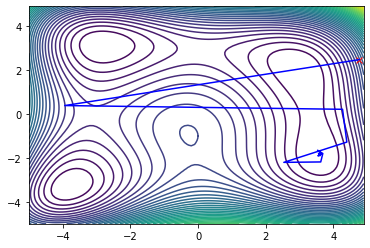

In [5]:
delta = 0.1
minXY=-5.0
maxXY=5.0
nContour=50
alpha=0.01

def J(x,*args):
    u"""
    Himmelblau's function
    see Himmelblau's function - Wikipedia, the free encyclopedia 
    http://en.wikipedia.org/wiki/Himmelblau%27s_function
    """
    return (x[0]**2+x[1]-11)**2+(x[0]+x[1]**2-7)**2

def CreateMeshData():
    x = np.arange(minXY, maxXY, delta)
    y = np.arange(minXY, maxXY, delta)
    X, Y = np.meshgrid(x, y)
    Z=[J(np.stack([x,y],axis=0)) for (x,y) in zip(X,Y)]
    return(X,Y,Z)

def jacobi(x,*args):
    dx = 4*x[0]**3 + 4*x[0]*x[1] - 42*x[0] +2*x[1]**2 -14
    dy = 2*x[0]**2 + 4*x[0]*x[1] + 4*x[1]**3 -26*x[1] -22
    return np.array([dx,dy])

start=np.array([random.uniform(minXY,maxXY),random.uniform(minXY,maxXY)])

x,jmin,resultc=CG(start,None)
(X,Y,Z)=CreateMeshData()
CS = plt.contour(X, Y, Z,nContour)
#  plt.clabel(CS, inline=1, fontsize=10)
#  plt.title('Simplest default with labels')

plt.plot(start[0],start[1],"xr");

optX=[x[0] for x in resultc]
optY=[x[1] for x in resultc]
plt.plot(optX,optY,"-b");

plt.show()

In [29]:
# MLEF

def L96(Xa,F):

    F_ = (np.roll(Xa, -1,axis=0) - np.roll(Xa, 2,axis=0)) * np.roll(Xa, 1,axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def Forecast(Xac,Xa,m,b):
    h = 0.05 
    F = 8.0
    
    #control
    Xfc = Rungekutta4(Xac,h,F)
    
    #ensemble
    Xf = np.empty((N,m))
    Xf = Rungekutta4(Xa,h,F)
    
    #Pf^(1/2)
    dXf = Xf - Xfc.reshape(-1,1)
    dXf = dXf*b
    #print(dXf)
    Pf = dXf @ dXf.T
    #Pf = Pf*L
    
    return Xfc,Xf,Pf,dXf

def Analysis(Xfc,Xf,dXf,y,m,a,mask):
    N = 40
    p = N-a
    R = np.eye(p)
    I = np.eye(m)
    
    R_inv = np.linalg.inv(R)
    R_sqrt = np.sqrt(R_inv)
    #z = R_sqrt@H(Xf,mask) - R_sqrt@H(Xfc,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    z = R_sqrt@H2(Xf,mask) - R_sqrt@H2(Xfc,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    C = z.T@z
    #print(C)
    
    la,v = np.linalg.eigh(C)
    #print(v)
    D = np.diag(1/np.sqrt(la+np.ones(m)))
    #print(D)
    V = np.array(v).reshape(m,m)
    A = V @ D @ V.T #(I+C)^(-T/2)
    
    zeta0 = np.zeros(m)
    args = (Xfc,dXf,A,y,R_inv,mask,H2)
    #res = optimize.minimize(J, zeta0, args=args, method='BFGS', jac=jacobi, options={'gtol':1e-6, 'disp':True})
    #zeta = res.x
    #jmin = res.fun
    #Pa_ = res.hess_inv #(I+C)^(-T/2)?
    zeta,jmin = CG(zeta0,*args)
    Xac = Xfc + dXf@A@zeta
    
    Xf = Xac.reshape(-1,1)+dXf
    #z_opt = R_sqrt@H(Xf,mask)- R_sqrt@H(Xac,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    z_opt = R_sqrt@H2(Xf,mask) - R_sqrt@H2(Xac,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    C_opt = z_opt.T@z_opt
    
    la,v = np.linalg.eigh(C_opt)
    #print(v)
    D = np.diag(1/np.sqrt(la+np.ones(m)))
    #print(D)
    V = np.array(v).reshape(m,m)
    A = V @ D @ V.T #(I+C_opt)^(-T/2)
    #print(A)
    
    dXa = dXf@A #Pf^(1/2)(I+C_opt)^(-T/2)
    
    Xa = np.zeros((N,m))
    Xa = dXa + Xac.reshape(-1,1)
    Pa = dXa@dXa.T
    
    return Xa,Pa,Xac,jmin

def J(zeta,*args):
    xb,dXf,A,y,R_inv,mask,H_obs = args
    B = A.T@A #(I+C)^(-1)
     
    x = xb + dXf@A@zeta
    inv = y - H_obs(x,mask)   
    return (zeta.T@B@zeta + inv.T@R_inv@inv)/2

def jacobi(zeta,*args):
    xb,dXf,A,y,R_inv,mask,H_obs = args
    B = A.T@A #(I+C)^(-1)
    R_sqrt = np.sqrt(R_inv)
    
    x = xb + dXf@A@zeta
    z = R_sqrt@H_obs(x.reshape(-1,1)+dXf,mask) - R_sqrt@H_obs(x,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    inv = y - H_obs(x,mask)
    djo = A.T@z.T@R_sqrt@inv
    return B@zeta - djo

def H(x,mask):
    xo = np.delete(x,mask,axis=0)
    return xo

def H2(x,mask):
    xo = np.delete(x,mask,axis=0)
    return xo**2

In [36]:
# MLEF(preconditioning)

def L96(Xa,F):

    F_ = (np.roll(Xa, -1,axis=0) - np.roll(Xa, 2,axis=0)) * np.roll(Xa, 1,axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def Forecast(Xac,Xa,m,b):
    h = 0.05 
    F = 8.0
    
    #control
    Xfc = Rungekutta4(Xac,h,F)
    
    #ensemble
    Xf = np.empty((N,m))
    Xf = Rungekutta4(Xa,h,F)
    
    #Pf^(1/2)
    dXf = Xf - Xfc.reshape(-1,1)
    dXf = dXf*b
    #print(dXf)
    Pf = dXf @ dXf.T
    #Pf = Pf*L
    
    return Xfc,Xf,Pf,dXf

def Analysis(Xfc,Xf,dXf,y,m,a,mask):
    N = 40
    p = N-a
    R = np.eye(p)
    I = np.eye(m)
    
    R_inv = np.linalg.inv(R)
    R_sqrt = np.sqrt(R_inv)
    #z = R_sqrt@H(Xf,mask) - R_sqrt@H(Xfc,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    #z = R_sqrt@H2(Xf,mask) - R_sqrt@H2(Xfc,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    z = R_sqrt@H3(Xf,mask) - R_sqrt@H3(Xfc,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    C = z.T@z
    #print(C)
    
    la,v = np.linalg.eigh(C)
    #print(v)
    D = np.diag(1/np.sqrt(la+np.ones(m)))
    #print(D)
    V = np.array(v).reshape(m,m)
    A = V @ D @ V.T #(I+C)^(-T/2)
    D_inv = np.diag(np.sqrt(np.ones(m)+la))
    A_inv = V @ D_inv @ V.T #(I+C)^(1/2)
    
    v0 = np.zeros(m)
    args = (Xfc,dXf,A,y,R_inv,mask,H3)
    res = optimize.minimize(J, v0, args=args, method='BFGS', jac=jacobi, options={'gtol':1e-4, 'disp':True})
    v = res.x
    jmin = res.fun
    #Pa_ = res.hess_inv #(I+C)^(-T/2)?
    #v,jmin = CG(v0,*args)
    #zeta = A_inv@v
    Xac = Xfc + dXf@v
    
    Xf = Xac.reshape(-1,1)+dXf
    #z_opt = R_sqrt@H(Xf,mask)- R_sqrt@H(Xac,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    #z_opt = R_sqrt@H2(Xf,mask) - R_sqrt@H2(Xac,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    z_opt = R_sqrt@H3(Xf,mask) - R_sqrt@H3(Xac,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    C_opt = z_opt.T@z_opt
    
    la,v = np.linalg.eigh(C_opt)
    #print(v)
    D = np.diag(1/np.sqrt(la+np.ones(m)))
    #print(D)
    V = np.array(v).reshape(m,m)
    A = V @ D @ V.T #(I+C_opt)^(-T/2)
    #print(A)
    
    dXa = dXf@A #Pf^(1/2)(I+C_opt)^(-T/2)
    
    Xa = np.zeros((N,m))
    Xa = dXa + Xac.reshape(-1,1)
    Pa = dXa@dXa.T
    
    return Xa,Pa,Xac,jmin

def J(v,*args):
    xb,dXf,A,y,R_inv,mask,H_obs = args
     
    x = xb + dXf@v
    inv = y - H_obs(x,mask)   
    return (v.T@v + inv.T@R_inv@inv)/2

def jacobi(v,*args):
    xb,dXf,A,y,R_inv,mask,H_obs = args
    R_sqrt = np.sqrt(R_inv)
    
    x = xb + dXf@v
    z = R_sqrt@H_obs(x.reshape(-1,1)+dXf,mask) - R_sqrt@H_obs(x,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    inv = y - H_obs(x,mask)
    djo = z.T@R_sqrt@inv
    return v - djo

def H(x,mask):
    xo = np.delete(x,mask,axis=0)
    return xo

def H2(x,mask):
    xo = np.delete(x,mask,axis=0)
    return xo**2

def H3(x,mask):
    xo = np.delete(x,mask,axis=0)
    return np.sqrt(xo**2)

         Current function value: 170.529283
         Iterations: 1
         Function evaluations: 37
         Gradient evaluations: 26
         Current function value: 118.074725
         Iterations: 9
         Function evaluations: 106
         Gradient evaluations: 94
Optimization terminated successfully.
         Current function value: 115.088216
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
         Current function value: 160.977073
         Iterations: 3
         Function evaluations: 105
         Gradient evaluations: 93
Optimization terminated successfully.
         Current function value: 171.174252
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
         Current function value: 172.843535
         Iterations: 8
         Function evaluations: 62
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 153.598601
         Iterations: 9
     

         Current function value: 214.757835
         Iterations: 3
         Function evaluations: 87
         Gradient evaluations: 75
Optimization terminated successfully.
         Current function value: 302.444352
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
         Current function value: 240.363806
         Iterations: 4
         Function evaluations: 98
         Gradient evaluations: 86
Optimization terminated successfully.
         Current function value: 232.505000
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
         Current function value: 198.203541
         Iterations: 8
         Function evaluations: 94
         Gradient evaluations: 82
         Current function value: 187.311091
         Iterations: 3
         Function evaluations: 61
         Gradient evaluations: 50
         Current function value: 110.365972
         Iterations: 5
         Function evaluations: 97
         Gra

         Current function value: 54.063822
         Iterations: 7
         Function evaluations: 70
         Gradient evaluations: 58
Optimization terminated successfully.
         Current function value: 53.410078
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 66.407745
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 46.078929
         Iterations: 7
         Function evaluations: 94
         Gradient evaluations: 82
Optimization terminated successfully.
         Current function value: 36.501815
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 52.166793
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Curre

         Current function value: 15.936255
         Iterations: 5
         Function evaluations: 93
         Gradient evaluations: 81
         Current function value: 26.132585
         Iterations: 4
         Function evaluations: 83
         Gradient evaluations: 71
Optimization terminated successfully.
         Current function value: 14.530819
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 12.744637
         Iterations: 5
         Function evaluations: 83
         Gradient evaluations: 71
         Current function value: 26.236752
         Iterations: 4
         Function evaluations: 101
         Gradient evaluations: 89
         Current function value: 21.355558
         Iterations: 6
         Function evaluations: 95
         Gradient evaluations: 83
Optimization terminated successfully.
         Current function value: 13.608190
         Iterations: 8
         Function evaluations: 10
         Gradient eva

         Current function value: 12.890850
         Iterations: 5
         Function evaluations: 94
         Gradient evaluations: 82
         Current function value: 26.439484
         Iterations: 7
         Function evaluations: 107
         Gradient evaluations: 95
Optimization terminated successfully.
         Current function value: 13.132600
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
         Current function value: 20.079222
         Iterations: 6
         Function evaluations: 77
         Gradient evaluations: 65
Optimization terminated successfully.
         Current function value: 15.697771
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 19.480119
         Iterations: 6
         Function evaluations: 96
         Gradient evaluations: 84
Optimization terminated successfully.
         Current function value: 31.444155
         Iterations: 9
         Function

         Current function value: 24.267494
         Iterations: 3
         Function evaluations: 95
         Gradient evaluations: 83
         Current function value: 38.503322
         Iterations: 6
         Function evaluations: 65
         Gradient evaluations: 54
Optimization terminated successfully.
         Current function value: 11.684542
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 21.398960
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 19.861176
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 19.005383
         Iterations: 7
         Function evaluations: 97
         Gradient evaluations: 85
Optimization terminated successfully.
         Current function value: 15.088854
       

         Current function value: 14.190543
         Iterations: 4
         Function evaluations: 97
         Gradient evaluations: 85
Optimization terminated successfully.
         Current function value: 15.852891
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
         Current function value: 15.298915
         Iterations: 6
         Function evaluations: 75
         Gradient evaluations: 64
         Current function value: 28.103863
         Iterations: 7
         Function evaluations: 91
         Gradient evaluations: 79
Optimization terminated successfully.
         Current function value: 23.115534
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 16.203470
         Iterations: 6
         Function evaluations: 65
         Gradient evaluations: 53
         Current function value: 21.053726
         Iterations: 4
         Function evaluations: 80
         Gradient eva

         Current function value: 21.553078
         Iterations: 4
         Function evaluations: 88
         Gradient evaluations: 76
         Current function value: 16.257017
         Iterations: 5
         Function evaluations: 75
         Gradient evaluations: 63
         Current function value: 22.687211
         Iterations: 3
         Function evaluations: 98
         Gradient evaluations: 86
Optimization terminated successfully.
         Current function value: 22.960051
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 18.503517
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 20.893122
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 20.547344
       

         Current function value: 28.854963
         Iterations: 6
         Function evaluations: 83
         Gradient evaluations: 71
Optimization terminated successfully.
         Current function value: 15.665495
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: 21.529468
         Iterations: 4
         Function evaluations: 102
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: 16.653773
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: 21.051132
         Iterations: 2
         Function evaluations: 73
         Gradient evaluations: 61
         Current function value: 15.794512
         Iterations: 2
         Function evaluations: 104
         Gradient evaluations: 92
         Current function value: 23.248987
         Iterations: 3
         Function evaluations: 100
         Gradient eva

Optimization terminated successfully.
         Current function value: 19.503743
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
         Current function value: 23.626736
         Iterations: 7
         Function evaluations: 105
         Gradient evaluations: 93
         Current function value: 24.510241
         Iterations: 6
         Function evaluations: 81
         Gradient evaluations: 69
         Current function value: 19.060667
         Iterations: 2
         Function evaluations: 106
         Gradient evaluations: 94
         Current function value: 17.557621
         Iterations: 4
         Function evaluations: 82
         Gradient evaluations: 70
Optimization terminated successfully.
         Current function value: 17.259410
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
         Current function value: 19.431024
         Iterations: 5
         Function evaluations: 99
         Gradient 

         Current function value: 16.901267
         Iterations: 2
         Function evaluations: 111
         Gradient evaluations: 99
Optimization terminated successfully.
         Current function value: 15.724688
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 23.172852
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 16.142676
         Iterations: 3
         Function evaluations: 98
         Gradient evaluations: 86
Optimization terminated successfully.
         Current function value: 10.813160
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 20.954763
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Current function value: 17.392173
        

         Current function value: 17.397207
         Iterations: 4
         Function evaluations: 103
         Gradient evaluations: 91
         Current function value: 14.001241
         Iterations: 3
         Function evaluations: 103
         Gradient evaluations: 91
         Current function value: 19.351666
         Iterations: 6
         Function evaluations: 98
         Gradient evaluations: 86
Optimization terminated successfully.
         Current function value: 21.619318
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 13.889575
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Current function value: 16.969777
         Iterations: 4
         Function evaluations: 98
         Gradient evaluations: 86
         Current function value: 19.294556
         Iterations: 5
         Function evaluations: 83
         Gradient ev

         Current function value: 24.229600
         Iterations: 5
         Function evaluations: 83
         Gradient evaluations: 71
         Current function value: 16.125095
         Iterations: 4
         Function evaluations: 98
         Gradient evaluations: 86
         Current function value: 16.073611
         Iterations: 2
         Function evaluations: 94
         Gradient evaluations: 82
Optimization terminated successfully.
         Current function value: 24.349258
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
         Current function value: 26.418197
         Iterations: 5
         Function evaluations: 88
         Gradient evaluations: 76
         Current function value: 13.679389
         Iterations: 4
         Function evaluations: 54
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 19.633567
         Iterations: 7
         Function evaluations: 8
         Gradient eva

         Current function value: 17.254626
         Iterations: 6
         Function evaluations: 75
         Gradient evaluations: 63
         Current function value: 17.598821
         Iterations: 2
         Function evaluations: 108
         Gradient evaluations: 96
         Current function value: 13.384611
         Iterations: 5
         Function evaluations: 81
         Gradient evaluations: 69
Optimization terminated successfully.
         Current function value: 18.671082
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 19.697445
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: 20.991949
         Iterations: 10
         Function evaluations: 79
         Gradient evaluations: 68
Optimization terminated successfully.
         Current function value: 26.302458
         Iterations: 9
         Function 

         Current function value: 20.803962
         Iterations: 5
         Function evaluations: 79
         Gradient evaluations: 67
         Current function value: 17.925654
         Iterations: 4
         Function evaluations: 106
         Gradient evaluations: 94
Optimization terminated successfully.
         Current function value: 14.509604
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 19.244423
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 18.370679
         Iterations: 9
         Function evaluations: 84
         Gradient evaluations: 72
Optimization terminated successfully.
         Current function value: 24.071693
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Current function value: 21.741739
         Iterations: 2
         Function eva

         Current function value: 19.191398
         Iterations: 4
         Function evaluations: 91
         Gradient evaluations: 79
         Current function value: 22.881462
         Iterations: 4
         Function evaluations: 56
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 27.608590
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 16.470463
         Iterations: 4
         Function evaluations: 97
         Gradient evaluations: 85
         Current function value: 15.698183
         Iterations: 4
         Function evaluations: 113
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 23.379033
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: 21.624620
         Iterations: 3
         Function evaluations: 88
         Gradient eval

         Current function value: 16.700100
         Iterations: 5
         Function evaluations: 107
         Gradient evaluations: 95
Optimization terminated successfully.
         Current function value: 18.935225
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: 19.819567
         Iterations: 6
         Function evaluations: 91
         Gradient evaluations: 79
         Current function value: 16.977826
         Iterations: 6
         Function evaluations: 91
         Gradient evaluations: 79
         Current function value: 25.348045
         Iterations: 5
         Function evaluations: 88
         Gradient evaluations: 76
         Current function value: 16.111987
         Iterations: 2
         Function evaluations: 48
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 23.390258
         Iterations: 8
         Function evaluations: 9
         Gradient eval

Optimization terminated successfully.
         Current function value: 20.513416
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: 12.171798
         Iterations: 5
         Function evaluations: 86
         Gradient evaluations: 74
         Current function value: 19.902116
         Iterations: 2
         Function evaluations: 105
         Gradient evaluations: 93
         Current function value: 14.884253
         Iterations: 2
         Function evaluations: 110
         Gradient evaluations: 98
         Current function value: 22.396954
         Iterations: 4
         Function evaluations: 103
         Gradient evaluations: 91
Optimization terminated successfully.
         Current function value: 22.479291
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 16.021867
         Iterations: 7
         Function

         Current function value: 23.101014
         Iterations: 5
         Function evaluations: 99
         Gradient evaluations: 87
         Current function value: 20.448084
         Iterations: 4
         Function evaluations: 93
         Gradient evaluations: 81
         Current function value: 23.411404
         Iterations: 5
         Function evaluations: 102
         Gradient evaluations: 90
         Current function value: 22.050899
         Iterations: 11
         Function evaluations: 72
         Gradient evaluations: 60
         Current function value: 24.895868
         Iterations: 4
         Function evaluations: 55
         Gradient evaluations: 43
         Current function value: 25.095984
         Iterations: 5
         Function evaluations: 96
         Gradient evaluations: 84
         Current function value: 12.162732
         Iterations: 9
         Function evaluations: 87
         Gradient evaluations: 75
         Current function value: 15.328413
         Iteratio

Optimization terminated successfully.
         Current function value: 21.430405
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 22.183511
         Iterations: 6
         Function evaluations: 84
         Gradient evaluations: 72
         Current function value: 28.986689
         Iterations: 5
         Function evaluations: 88
         Gradient evaluations: 76
         Current function value: 25.866561
         Iterations: 5
         Function evaluations: 109
         Gradient evaluations: 97
         Current function value: 15.245592
         Iterations: 4
         Function evaluations: 93
         Gradient evaluations: 81
Optimization terminated successfully.
         Current function value: 23.917501
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
         Current function value: 20.982927
         Iterations: 3
         Function evaluations: 117
         Gradient ev

         Current function value: 19.967917
         Iterations: 5
         Function evaluations: 100
         Gradient evaluations: 88
Optimization terminated successfully.
         Current function value: 22.377000
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
         Current function value: 20.082152
         Iterations: 3
         Function evaluations: 88
         Gradient evaluations: 76
Optimization terminated successfully.
         Current function value: 22.092834
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 13.743767
         Iterations: 3
         Function evaluations: 96
         Gradient evaluations: 84
         Current function value: 15.942673
         Iterations: 7
         Function evaluations: 82
         Gradient evaluations: 70
         Current function value: 19.186757
         Iterations: 3
         Function evaluations: 64
         Gradient eva

         Current function value: 17.578662
         Iterations: 4
         Function evaluations: 133
         Gradient evaluations: 121
Optimization terminated successfully.
         Current function value: 22.593662
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
         Current function value: 18.084485
         Iterations: 7
         Function evaluations: 92
         Gradient evaluations: 80
Optimization terminated successfully.
         Current function value: 23.731018
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 18.298659
         Iterations: 3
         Function evaluations: 109
         Gradient evaluations: 97
         Current function value: 18.460904
         Iterations: 7
         Function evaluations: 94
         Gradient evaluations: 82
Optimization terminated successfully.
         Current function value: 17.664225
         Iterations: 8
         Funct

         Current function value: 20.282405
         Iterations: 6
         Function evaluations: 88
         Gradient evaluations: 76
         Current function value: 16.686584
         Iterations: 4
         Function evaluations: 105
         Gradient evaluations: 93
Optimization terminated successfully.
         Current function value: 18.061316
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 20.001182
         Iterations: 5
         Function evaluations: 87
         Gradient evaluations: 75
         Current function value: 26.517170
         Iterations: 10
         Function evaluations: 100
         Gradient evaluations: 88
         Current function value: 19.480231
         Iterations: 5
         Function evaluations: 94
         Gradient evaluations: 82
         Current function value: 12.404568
         Iterations: 5
         Function evaluations: 87
         Gradient evaluations: 75
         Current functi

Optimization terminated successfully.
         Current function value: 18.541610
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 25.721114
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 19.939223
         Iterations: 7
         Function evaluations: 91
         Gradient evaluations: 79
         Current function value: 15.560805
         Iterations: 3
         Function evaluations: 94
         Gradient evaluations: 82
         Current function value: 18.718768
         Iterations: 5
         Function evaluations: 95
         Gradient evaluations: 83
Optimization terminated successfully.
         Current function value: 17.874415
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 15.677072
     

         Current function value: 18.928805
         Iterations: 5
         Function evaluations: 98
         Gradient evaluations: 86
         Current function value: 19.506899
         Iterations: 3
         Function evaluations: 91
         Gradient evaluations: 79
         Current function value: 19.082566
         Iterations: 7
         Function evaluations: 49
         Gradient evaluations: 38
         Current function value: 20.297578
         Iterations: 2
         Function evaluations: 54
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 24.609078
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 26.334263
         Iterations: 4
         Function evaluations: 96
         Gradient evaluations: 84
         Current function value: 18.131046
         Iterations: 7
         Function evaluations: 88
         Gradient evaluations: 76
         Current function 

         Current function value: 18.788528
         Iterations: 5
         Function evaluations: 102
         Gradient evaluations: 90
         Current function value: 17.638302
         Iterations: 7
         Function evaluations: 84
         Gradient evaluations: 72
Optimization terminated successfully.
         Current function value: 11.888270
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 14.964980
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: 16.821870
         Iterations: 5
         Function evaluations: 96
         Gradient evaluations: 84
         Current function value: 19.379286
         Iterations: 3
         Function evaluations: 94
         Gradient evaluations: 82
Optimization terminated successfully.
         Current function value: 23.569587
         Iterations: 8
         Function e

         Current function value: 15.928835
         Iterations: 5
         Function evaluations: 88
         Gradient evaluations: 76
Optimization terminated successfully.
         Current function value: 13.514500
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 24.112184
         Iterations: 4
         Function evaluations: 108
         Gradient evaluations: 96
Optimization terminated successfully.
         Current function value: 22.773640
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 18.106534
         Iterations: 4
         Function evaluations: 88
         Gradient evaluations: 76
Optimization terminated successfully.
         Current function value: 16.791494
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Current function value: 16.320346
         Iterations: 4
         Function eva

         Current function value: 13.311296
         Iterations: 3
         Function evaluations: 107
         Gradient evaluations: 95
         Current function value: 18.083168
         Iterations: 6
         Function evaluations: 90
         Gradient evaluations: 78
         Current function value: 18.025084
         Iterations: 9
         Function evaluations: 88
         Gradient evaluations: 76
         Current function value: 18.593458
         Iterations: 6
         Function evaluations: 81
         Gradient evaluations: 69
         Current function value: 23.535278
         Iterations: 4
         Function evaluations: 96
         Gradient evaluations: 84
         Current function value: 16.164387
         Iterations: 4
         Function evaluations: 82
         Gradient evaluations: 70
         Current function value: 22.457984
         Iterations: 6
         Function evaluations: 100
         Gradient evaluations: 88
         Current function value: 21.270639
         Iteratio

         Current function value: 19.971694
         Iterations: 6
         Function evaluations: 104
         Gradient evaluations: 92
Optimization terminated successfully.
         Current function value: 17.991035
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 25.540551
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: 19.861279
         Iterations: 4
         Function evaluations: 92
         Gradient evaluations: 80
Optimization terminated successfully.
         Current function value: 12.340665
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 22.350308
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Curr

         Current function value: 19.905707
         Iterations: 6
         Function evaluations: 75
         Gradient evaluations: 63
         Current function value: 18.885300
         Iterations: 5
         Function evaluations: 101
         Gradient evaluations: 89
Optimization terminated successfully.
         Current function value: 21.546133
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: 21.060063
         Iterations: 4
         Function evaluations: 89
         Gradient evaluations: 77
Optimization terminated successfully.
         Current function value: 13.512938
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Current function value: 31.643053
         Iterations: 3
         Function evaluations: 92
         Gradient evaluations: 80
Optimization terminated successfully.
         Current function value: 14.893201
         Iterations: 6
         Function e

         Current function value: 16.997502
         Iterations: 3
         Function evaluations: 106
         Gradient evaluations: 94
Optimization terminated successfully.
         Current function value: 33.360098
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 18.915316
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Current function value: 20.871033
         Iterations: 8
         Function evaluations: 97
         Gradient evaluations: 85
         Current function value: 24.565162
         Iterations: 7
         Function evaluations: 75
         Gradient evaluations: 63
         Current function value: 25.702793
         Iterations: 4
         Function evaluations: 96
         Gradient evaluations: 84
         Current function value: 15.498690
         Iterations: 2
         Function evaluations: 108
         Gradient ev

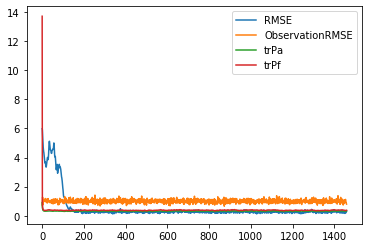

rmse 0.2585475825429618
trPa 0.31487405467304264
trPf 0.38000815967195234
<Jmin> 28.95766117817735


In [37]:

t = 1460
N = 40
m = 20
h = 0.05 
F = 8.0

#初期値
X0 = np.random.rand(N)
for j in range(500):
    X1 = Rungekutta4(X0,h,F)
    X0 = X1
Xac = X1

Xa = np.empty((N,m))
Xc = np.random.rand(N,m)*5.0
Xa = Xac.reshape(-1,1) + Xc
#plt.plot(Xa[:,9])
#plt.plot(Xa[:,8])
#plt.show()

dataset = pd.read_csv("observation_data3.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data3.csv")
Xt = dataset2.values.reshape(t,N)
RMSE = []
TrPa = []
TrPf = []
A = []
B = []
Jmin = []
a = 0 # observation miss
b = 1.1 # inflation
trPa = []
trPf = []
R = []
Rf = []
R_ = []
RO = []
for k in range(t):
    mask = np.random.choice(40,a,replace=False)
    y_ =np.delete(Y[k],mask)
    
    (Xfc,Xf,Pf,dXf) = Forecast(Xac,Xa,m,b)
    (Xa,Pa,Xac,jmin) = Analysis(Xfc,Xf,dXf,y_,m,a,mask)
    #print(Xf)
    Jmin.append(jmin)
    
    rmse=np.zeros(m)
    rmsef = np.zeros(m)
    rmse_=0.0
    X1 = Xt[k]
    rmse = np.sqrt(np.sum((Xa-X1.reshape(-1,1))*(Xa-X1.reshape(-1,1)),axis=0)/N)
    rmsef = np.sqrt(np.sum((Xf-X1.reshape(-1,1))*(Xf-X1.reshape(-1,1)),axis=0)/N)
    rmse_ = np.sqrt(np.sum((Xac-X1)*(Xac-X1))/N) 
    Y1 = y_
    #X1 = H(Xt[k],mask)
    #X1 = H2(Xt[k],mask)
    X1 = H3(Xt[k],mask)
    rmseo = np.sqrt(np.sum((Y1-X1)*(Y1-X1))/(N-a))
    err = np.sqrt(np.sum(np.diag(Pa))/N)
    err2 = np.sqrt(np.sum(np.diag(Pf))/N)
    trPa.append(abs(err))
    trPf.append(abs(err2))
    R.append(rmse)
    Rf.append(rmsef)
    R_.append(rmse_)
    RO.append(rmseo)
    #if(k%100==0):
    #   print(k)
rb = np.sum(np.array(R_[500:]))/(t-500)
trPab = np.sum(np.array(trPa[500:]))/(t-500)
trPfb = np.sum(np.array(trPf[500:]))/(t-500)
RMSE.append(rb)
TrPa.append(trPab)
TrPf.append(trPfb)
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObservationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("SRF.jpg")
plt.show()
print("rmse",np.mean(R_[500:]))
print("trPa",np.mean(trPa[500:]))
print("trPf",np.mean(trPf[500:]))
print("<Jmin>",np.mean(np.array(Jmin)))

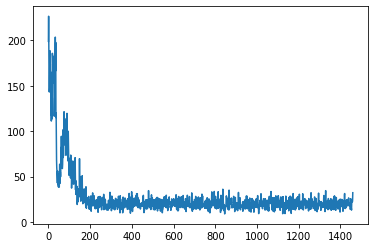

In [14]:
plt.plot(Jmin)